In [34]:
# read variables iwc,zKu, iwc_label and zw_label from file cloudSat_thr01.nc
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
with nc.Dataset('cloudSat_thr01.nc','r') as f:
    iwc=f.variables['iwc'][:]
    zW=f.variables['zKu'][:]
    iwc_label=f.variables['iwc_label18'][:]
    zw_label=f.variables['zw_label18'][:]
    print(iwc.shape)



(138606, 50)


In [12]:
import pickle
from kazrRet import *
d=pickle.load(open('iwcCoeff.pkl','rb'))
iwcCoeff=d['iwcCoeff']
peak=d['peak']
iwcCoeff_SSRG=np.polyfit(zST[2,:],np.log10(iwcST[2,:]),1)
print(iwcCoeff_SSRG)
#print(iwcCoeff)

[ 0.08061103 -1.50649553]


In [10]:
print(zW.shape)
print(iwc_label.max())
print(iwcCoeff.shape)

(138606, 50)
35
(18, 2)


In [13]:
nC=36
iwc_CSL=np.zeros((nC),float)
iwc_CSLn=np.zeros((nC),float)
iwc_SSRGL=np.zeros((nC),float)
for i in range(nC):
    a=np.nonzero(iwc_label==i)
    s1=0
    s2=0
    s3=0
    for k in a[0]:
        zw1=zW[k,:]
        a1=np.nonzero(zw1>-22)
        iwc1_SSRG=10**(iwcCoeff_SSRG[0]*zw1[a1]+iwcCoeff_SSRG[1])
        iwc1_CS=10**(iwcCoeff[i,0]*zw1[a1]+iwcCoeff[i,1])
        s1+=np.sum(iwc1_SSRG)
        s2+=np.sum(iwc[k,a1])
        s3+=np.sum(iwc1_CS)
    #print(s3/s2)
    iwc_CSL[i]=s3
    iwc_CSLn[i]=s2
    iwc_SSRGL[i]=s1


In [92]:
#print(iwc_CSLn.sum()/iwc_SSRGL.sum())
#plt.hist(iwc_CSLn/iwc_CSL)
#plt.figure()
#plt.scatter(-np.log10(iwc_SSRGL/iwc_CSLn)+np.log10(1.11),peak)
#print(np.corrcoef(-np.log10(iwc_SSRGL/iwc_CSLn),peak))
#dnCoeff=np.polyfit(peak,-np.log10(iwc_SSRGL/iwc_CSL)+np.log10(1.11),1)
#print(dnCoeff)
dnCoeff=np.array([0.01381017, 0.54397871])
dnCoeff=np.array([0.01975583*1.5, 0.22])
dn1D=np.polyval(dnCoeff,range(50))
#print(10**(dn1D))
#print(iwcCoeff_SSRG)

In [93]:
with nc.Dataset('kext_atm_allChannels.nc','r') as f:
    kext_atm=f.variables['kext_atm'][:]
    kext_atm=np.array(kext_atm)

with nc.Dataset('profiles.nc','r') as f:
    qv=f.variables['qv'][:]
    press=f.variables['press'][:]
    temp=f.variables['temp'][:]
    tempm=f.variables['tempm'][:]
    pressf=f.variables['pressf'][:]
    rho=f.variables['rho'][:]
print(qv.shape)
print(temp[0,:])
print(press[0,:])
kextCoeffL=[np.polyfit(zST[k,:200],np.log10(kextST[k,:200]),1) for k in range(4)]

npart=4
undef=0.0
nrefl=2
ice_type=1
import lidarSim as lidar
def get_pnorm(nz,dr,temp1,pres1,presf1,qv1,iwc1,rho1,dm_ice):
    h1=dr/2+np.arange(nz)*dr
    h1f=np.arange(nz)*dr
    q_lsice1=iwc1/rho1*1e-3
    q_lsice=q_lsice1[np.newaxis,:]
    pres1=pres1[np.newaxis,:]
    presf1=presf1[np.newaxis,:]
    temp1=temp1[np.newaxis,:]
    q_lsliq=np.zeros((1,nz),float)
    ls_radice=dm_ice/2*1e-3
    ls_radice=ls_radice[np.newaxis,:]
    ls_radliq=np.zeros((1,nz),float)
    q_cvice=np.zeros((1,nz),float)
    cv_radice=np.zeros((1,nz),float)
    q_cvliq=np.zeros((1,nz),float)
    cv_radliq=np.zeros((1,nz),float)
    temp=temp1
    pres=pres1
    presf=presf1
    pmol,pnorm,pnorm_perp_tot,\
        tautot,betatot_liq,\
        betatot_ice,\
        betatot,refl, \
        zheight,\
        beta_mol, tau_mol,\
        alpha= lidar.lidar_simulator(npart,nrefl,undef,\
                                     pres1,presf1,\
                                     temp1,
                                     q_lsliq,q_lsice,\
                                     q_cvliq,\
                                     q_cvice,\
                                     ls_radliq,\
                                     ls_radice,\
                                     cv_radliq,cv_radice,\
                                     ice_type)
    return pmol,pnorm


(30, 64)
[293.40045681 292.52734447 291.51416842 290.38669677 289.15483565
 287.84019003 286.46221925 285.03606483 283.5873762  282.15206722
 280.73192701 279.31027085 277.88179166 276.41490655 274.91035638
 273.36047421 271.77059455 270.18039954 268.59145585 267.01852674
 265.4562701  263.91411141 262.38302547 260.87403106 259.37831043
 257.91778156 256.48023174 255.04984268 253.62245589 252.18479849
 250.73121018 249.25901215 247.76401613 246.2404841  244.69591532
 243.11523133 241.50428963 239.83628386 238.09060678 236.27068844
 234.20625564 232.07620854 229.86211791 227.64030174 225.41194687
 223.13162896 220.85874284 218.8322912  217.21110002 216.04230508
 215.41307229 215.02846052 214.58038636 213.72484911 212.41191065
 211.11187024 210.43280253 210.86905914 212.03109391 213.56278865
 214.82329557 215.75705987 216.09739124 216.16402745 215.86124935]
[92649.2040055  90114.77490028 87638.15450986 85222.34632105
 82865.15275391 80558.85363472 78294.728126   76103.02677105
 73947.872

In [96]:
import lidarSim as lidSim
fisot=2.7
umu=np.cos(np.deg2rad(0.0))
nt1,nz=qv.shape
height=np.arange(nz+1)*0.240
nt=zW.shape[0]
iwc_SSRG=np.zeros((nt,50),float)
dm_SSRG=np.zeros((nt,50),float)

#dn1D*=0
dmCoeff=np.polyfit(zST[2,:],np.log10(dmST[2,:]),1)
iwcLowCoeff=np.polyfit(zST[2,:200],np.log10(iwcST[2,:200]),1)
kextCoeffL=[np.polyfit(zST[k,:200],np.log10(kextST[k,:200]),1) for k in range(5)]
print(kextCoeffL)
print(dmCoeff)
dn1Da=dn1D+1.0
tbL=[]
epsL=[]
zKu=np.zeros((nt,50),float)-99.9
zKuL=[]
pnormL=[]
dm_SSRGL=[]
dnL=[]
ifreqC=[0,1,2,3,3,3,3,3,3,4,4,4]
from scipy.ndimage import gaussian_filter1d
for i in range(nt):
    zw1=zW[i,:]
    a1=np.nonzero(zw1>-22)
    kextI=np.zeros((50,12),float)
    salbI=np.zeros((50,12),float)
    asymI=np.zeros((50,12),float)
    ic=np.random.randint(0,30)
    kext1D=kext_atm[ic,:,:].copy()
    salb1D=np.zeros((64,12),float)
    asym1D=np.zeros((64,12),float)
    dnp=np.random.randn(64)
    dnp=gaussian_filter1d(dnp,2)
    dn1Dp=dn1Da+dnp[14:64]*2
    for k in a1[0]:
        ifind = lidSim.bisection2(zST[2,:],zw1[k]-10*(dn1Dp[k]))
        iwc_SSRG[i,k]=iwcST[2,ifind]*10**(dn1Dp[k])
        zKu[i,k]=zST[0,ifind]+10*(dn1Dp[k])
        dm_SSRG[i,k]=10**(dmCoeff[0]*(zw1[k]-10*dn1Da[k])+dmCoeff[1]+dn1Dp[k])
        if ifind==1:
            iwc_SSRG[i,k]=10**(iwcLowCoeff[0]*(zw1[k]-10*dn1Dp[k])+iwcLowCoeff[1]+dn1Dp[k])
            for ifreq in range(12):
                ifreq1=ifreqC[ifreq]
                kextI[k,ifreq]=10**(kextCoeffL[ifreq1][0]*(zw1[k]-10*dn1Dp[k])+kextCoeffL[ifreq1][1]+dn1Dp[k])
                salbI[k,ifreq]=kextI[k,ifreq]*kscaST[ifreq1,0]/kextST[ifreq1,0]  
                asymI[k,ifreq]=gST[ifreq1,0]
                #kextI[k,ifreq]=kextST[ifreq1,ifind]*10**(dn1Dp[k])
                #salbI[k,ifreq]=kscaST[ifreq1,ifind]
                #asymI[k,ifreq]=gST[ifreq1,ifind]
            zKu[i,k]=zw1[k]
        else:
            for ifreq in range(12):
                ifreq1=ifreqC[ifreq]
                kextI[k,ifreq]=kextST[ifreq1,ifind]*10**(dn1Dp[k])
                salbI[k,ifreq]=kscaST[ifreq1,ifind]*10**(dn1Dp[k])
                asymI[k,ifreq]=gST[ifreq1,ifind]
    nz=50
    dr=0.240
    temp1=temp[ic,14:64]
    pres1=press[ic,14:64]
    presf1=pressf[ic,14:65]
    qv1=qv[ic,14:64]
    iwc1=iwc_SSRG[i,:]
    rho1=pres1/(287.05*temp1)
    dm_ice=dm_SSRG[i,:]
    dnL.append(dn1Dp.copy())
    pmol,pnorm=get_pnorm(nz,dr,temp1,pres1,presf1,qv1,iwc1,rho1,dm_ice)
    
    kext1D[14:64,:]+=kextI[:,:]
    salb1D[14:64,:]=salbI[:,:]
    asym1D[14:64,:]=asymI[:,:]
    salb1D/=kext1D
    emis=0.8+np.random.random()*0.2
    ebar=emis
    tb1=[]
    for ik in range(2,12):
        #print(dn1Dp)
        tbout = lidSim.radtran(umu,temp[ic][0],temp[ic],height,kext1D[:,ik],salb1D[:,ik],asym1D[:,ik],fisot,emis,ebar)
        tb1.append(tbout)
        if tbout!=tbout:
            #print(ik)
            stop
    tbL.append(tb1)
    zKuL.append(zKu[i,:])
    epsL.append(emis)
    dm_SSRGL.append(dm_ice)
    pnormL.append(pnorm[0,:])
    


[array([ 0.0650893 , -5.46457907]), array([ 0.08109559, -4.27010811]), array([ 0.1017678 , -2.50325669]), array([ 0.1205315 , -0.80303825]), array([0.11884012, 0.49292114])]
[ 0.0200911  -0.12390667]


[0.22       0.24963374 0.27926749 0.30890123 0.33853498 0.36816872
 0.39780247 0.42743621 0.45706996 0.4867037  0.51633745 0.54597119
 0.57560494 0.60523868 0.63487243 0.66450617 0.69413992 0.72377366
 0.75340741 0.78304115 0.8126749  0.84230864 0.87194239 0.90157613
 0.93120988 0.96084362 0.99047737 1.02011111 1.04974486 1.0793786
 1.10901235 1.13864609 1.16827984 1.19791359 1.22754733 1.25718107
 1.28681482 1.31644856 1.34608231 1.37571605 1.4053498  1.43498354
 1.46461729 1.49425103 1.52388478 1.55351852 1.58315227 1.61278601
 1.64241976 1.6720535 ]
[0.02963374 0.22      ]


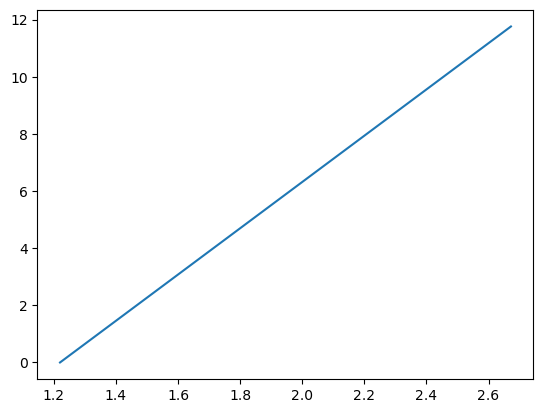

In [95]:
#print(salb1D[:,ik])
plt.plot(dn1Da,np.arange(50)*0.240)
print(np.polyval(dnCoeff,range(50)))
print(dnCoeff)

In [41]:
import xarray as xr
ds=xr.Dataset({'tb':(['time','chan'],tbL),
                'zKu':(['time','height'],zKuL),
                'pnorm':(['time','height'],1e3*np.array(pnormL)),
                'iwc_SSRG':(['time','height'],iwc_SSRG),
                'iwcCS':(['time','height'],iwc),
                'eps':(['time'],epsL),
                'dm_SSRG':(['time','height'],dm_SSRGL),
                'dnw':(['time','height'],dnL)},
                coords={'time':np.arange(len(tbL)),
                        'chan':np.arange(10),
                        'height':np.arange(50)})

#ds.to_netcdf('simObsInclined.nc',format='NETCDF4')
ds.to_netcdf('simObsCrossTrack_2dn.nc',format='NETCDF4',encoding={'tb':{'zlib':True,'complevel':5},\
    'zKu':{'zlib':True,'complevel':5},'iwc_SSRG':{'zlib':True,'complevel':5},'iwcCS':{'zlib':True,'complevel':5},\
        'pnorm':{'zlib':True,'complevel':5},'dm_SSRG': {'zlib': True, 'complevel': 9},\
        'eps':{'zlib':True,'complevel':5},'dnw':{'zlib':True,'complevel':5}})  



6.309573444801933


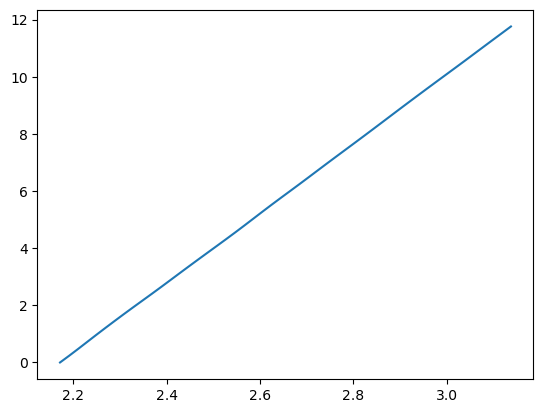

In [53]:
plt.plot(np.array(dnL).mean(axis=0),np.arange(50)*0.24)
print(10**0.8)

In [150]:
print(np.array(pnormL).shape)
#print(tbL)
#write ds to a compressed netcdf file using encoding
#ds.to_netcdf('simObsInclined.nc',format='NETCDF4',encoding={'tb':{'zlib':True,'complevel':5},
#'zKu':{'zlib':True,'complevel':5},'eps':{'zlib':True,'complevel':5}})  




(10, 1, 50)


0.06873033762232066
0.078562036
[[1.         0.92743434]
 [0.92743434 1.        ]]


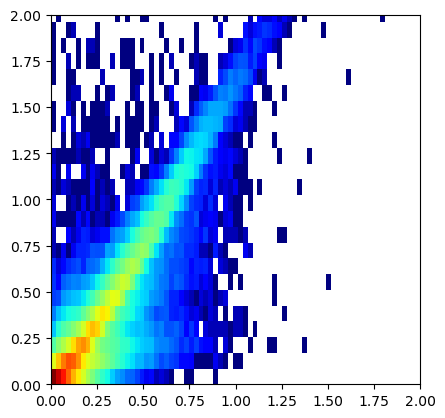

In [105]:
#print(dn1D)
a=np.nonzero(iwc_SSRG>0)
print(iwc_SSRG[a].mean())
print(iwc[a].mean())
print(np.corrcoef(iwc_SSRG[a],iwc[a]))
ax=plt.subplot(111)
iwc_hist2d=plt.hist2d(iwc_SSRG[a],iwc[a],bins=100,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.xlim(0,2)
plt.ylim(0,2)
ax.set_aspect('equal')